In [2]:
#Import Libraries
import numpy as np #linear algebra
import pandas as pd #data processing
import matplotlib.pyplot as plt #data viz
import seaborn as sns #data viz
from sklearn.impute import SimpleImputer #imputes missing vals
from datetime import datetime 
from sklearn.preprocessing import StandardScaler, OneHotEncoder #preprocessing
from sklearn.compose import ColumnTransformer #preprocessing
from sklearn.decomposition import PCA #dimensionality reduction
from sklearn.cluster import DBSCAN #clustering
from sklearn.model_selection import train_test_split, GridSearchCV #data split, grid search
from imblearn.over_sampling import SMOTE #balance classes
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.svm import SVC #support vector machine
from sklearn.neighbors import KNeighborsClassifier #knn
from sklearn.naive_bayes import GaussianNB #bayes
from xgboost import XGBClassifier #gradient boosting tree
from sklearn.metrics import accuracy_score, recall_score #calculates accuracy, recall
from sklearn.ensemble import VotingClassifier#ensemble

ModuleNotFoundError: No module named 'imblearn'

In [3]:
pd.set_option('display.max_columns', None)
customer_data = pd.read_csv('marketing_campaign.csv',
                           delimiter='\t', index_col='ID')
customer_data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [4]:
#Feature Engineering
#Create 'Age' feature from customer's birth year
customer_data['Age'] = customer_data.Year_Birth.apply(lambda x: 2021 - int(x))

#Create 'Days_Since_Customer' feature from time the customer enrolled
customer_data['Dt_Customer'] = pd.to_datetime(customer_data.Dt_Customer)
now = datetime.now()
customer_data['Days_Since_Customer'] = customer_data.Dt_Customer.apply(lambda x: (now - x).total_seconds()/ (60 * 60 * 24))

#Create 'Fam_Size' feature from the marriage status, number of kids/teens
marital_map = {'Absurd': 1, 'Alone': 1, 'YOLO': 1, 'Single': 1,
              'Married': 2, 'Together': 2, 'Widow': 1, 'Divorced': 1}
customer_data['Marital_Status'] = customer_data.Marital_Status.map(marital_map) #Maps all singles as 1, couples as 2
customer_data['Num_Kids'] = customer_data.Kidhome.values + customer_data.Teenhome.values
customer_data['Fam_Size'] = customer_data.Marital_Status.values + customer_data.Num_Kids.values

#Create 'Num_Accepted' feature from the sum of previous marketting campaigns that were accepted by the customer
customer_data['Num_Accepted'] = customer_data.AcceptedCmp1.values + customer_data.AcceptedCmp2.values + \
                                customer_data.AcceptedCmp3.values + customer_data.AcceptedCmp4.values + \
                                customer_data.AcceptedCmp5.values

#Create 'MntTotal' for total amount spent on all items
customer_data['MntTotal'] = customer_data['MntWines'].values + customer_data['MntFruits'].values + \
                            customer_data['MntMeatProducts'].values + customer_data['MntFishProducts'].values + \
                            customer_data['MntWines'].values + customer_data['MntSweetProducts'].values + \
                            customer_data['MntGoldProds'].values

#Drops the unnecessary features from the original dataset
customer_data.drop(['Dt_Customer', 'Year_Birth', 'AcceptedCmp1', 'AcceptedCmp2',
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Kidhome', 'Teenhome',
                   'Z_CostContact', 'Z_Revenue', 'Num_Kids', 'Marital_Status'],
                   axis=1, inplace=True)
customer_data.head() 

/var/folders/xp/fzj8h07x52n24_x835lrmtbr0000gn/T/ipykernel_93425/2866335758.py:6: UserWarning: Parsing '21-08-2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  customer_data['Dt_Customer'] = pd.to_datetime(customer_data.Dt_Customer)
/var/folders/xp/fzj8h07x52n24_x835lrmtbr0000gn/T/ipykernel_93425/2866335758.py:6: UserWarning: Parsing '19-01-2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  customer_data['Dt_Customer'] = pd.to_datetime(customer_data.Dt_Customer)
/var/folders/xp/fzj8h07x52n24_x835lrmtbr0000gn/T/ipykernel_93425/2866335758.py:6: UserWarning: Parsing '13-11-2012' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  customer_data['Dt_Customer'] = pd.to_datetime(customer_data.Dt_Customer)
/var/folders/xp/fzj8h07x52n24_x835lrmtbr0000gn/T/ipykernel_93425/2866335758.py:6: UserWarning: Parsing '13-03-2014' in DD/MM/YYYY 

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Response,Age,Days_Since_Customer,Fam_Size,Num_Accepted,MntTotal
ID,,,,,,,,,,,,,,,,,,,,,
5524,Graduation,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,0,1,64,3873.865577,1,0,2252
2174,Graduation,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,0,0,67,3027.865577,3,0,38
4141,Graduation,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,56,3374.865577,2,0,1202
6182,Graduation,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,37,2967.865577,3,0,64
5324,PhD,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,40,3223.865577,3,0,595


In [5]:
#Prints the size of the dataset
print('Dataset Shape:', customer_data.shape)
print('-------------------------------')
#Check if any columns contain null
print('Total Nulls Per Column:')
print(customer_data.isnull().sum())

Dataset Shape: (2240, 21)
-------------------------------
Total Nulls Per Column:
Education               0
Income                 24
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Complain                0
Response                0
Age                     0
Days_Since_Customer     0
Fam_Size                0
Num_Accepted            0
MntTotal                0
dtype: int64


In [6]:
#Imputes the mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(customer_data.Income.values.reshape(-1,1))
customer_data['Income'] = imputer.transform(customer_data.Income.values.reshape(-1,1))

In [7]:
#Calculate percent of responses
pos_resp = customer_data.Response.sum()
total = customer_data.shape[0]
percent = round((pos_resp / total)*100, 2)

print(pos_resp, 'customers responded to the marketing campaign out of a total of', total, 'cutomers.')
print('Percent Responded: ' +  str(percent) + '%')

334 customers responded to the marketing campaign out of a total of 2240 cutomers.
Percent Responded: 14.91%


In [8]:
#Remove the 'Response' column because it is the target of future predictive model
X, y = customer_data.drop('Response', axis=1).values, customer_data['Response'].values

#Creates a column transformer that sends 'Education' to be encoded and rest scaled
ct = ColumnTransformer([
    ('catagoric', OneHotEncoder(), [0]),
    ('numeric', StandardScaler(), list(range(1, len(X.T))))
])

#Sends the data through the column transformer
X_transformed = ct.fit_transform(X)
print('Preprocessed Data:')
print(X_transformed[0])

Preprocessed Data:
[ 0.          0.          1.          0.          0.          0.23532677
  0.30703926  0.98378127  1.55157698  1.67970233  2.46214705  1.4765001
  0.84320691  0.34941394  1.40930394  2.51089024 -0.55078479  0.69390374
 -0.09728167  0.98534473  1.97674456 -1.75911463 -0.43903713  1.4669731 ]


In [9]:
#Create instance of Principal Component Analysis in order to reduce dimensionality while maintaining variance
#n_components=3 will be chosen in order to visualize the data better
pca = PCA(n_components=3)

#fit to dataset
pca.fit(X_transformed)

#create dimentionality reduced dataset
X_reduced = pca.transform(X_transformed)

print('Dimentionality Reduced Data:')
print(X_reduced[0])

Dimentionality Reduced Data:
[ 4.19629277  1.01591743 -2.28901539]


In [10]:
#Create an instance of DBSCAN to create non spherical clusters based on data density
db = DBSCAN(eps=0.726, min_samples=26)

#fit to the dimentionality reduced dataset
db.fit(X_reduced)

#identify the clusters
clusters = db.labels_

#display metrics/sample
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Cluster Predictions')
print('-------------------------------')
print("Number of clusters: %d" % n_clusters_)
print("Number of noise points: %d" % n_noise_)
print('Number of points per cluster:')
for i in range(n_clusters_):
    print('Cluster', i, ':', len(clusters[clusters==i]))

Cluster Predictions
-------------------------------
Number of clusters: 3
Number of noise points: 751
Number of points per cluster:
Cluster 0 : 1293
Cluster 1 : 29
Cluster 2 : 167


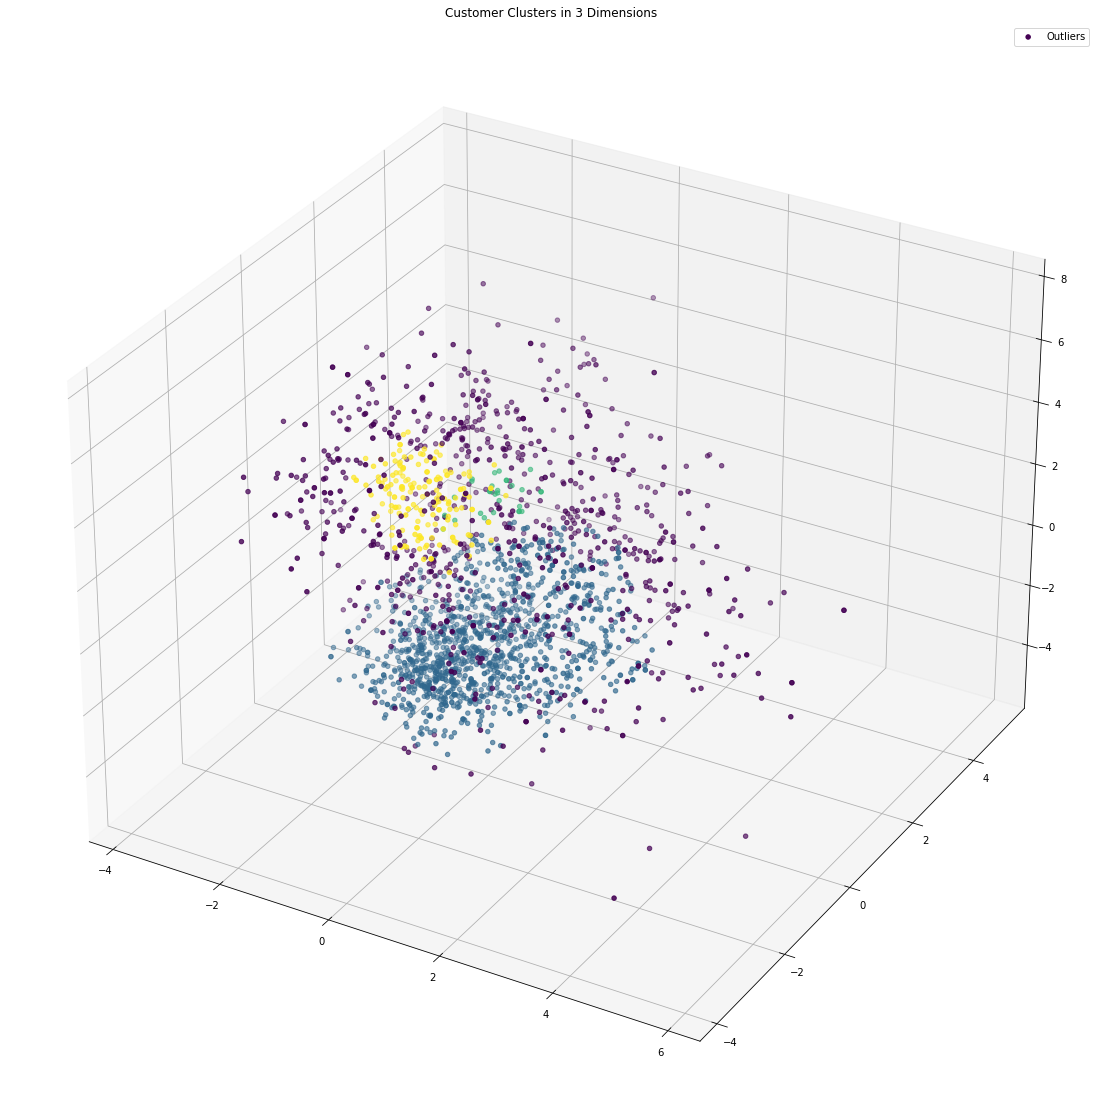

In [11]:
#plot the 3d dataset
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_reduced.T[1],X_reduced.T[2],X_reduced.T[0], 
           c=clusters)
ax.set_title("Customer Clusters in 3 Dimensions")
ax.legend(['Outliers'])
plt.show()
